In [1]:
import sys, os
import numpy as np
import pandas as pd
from geopandas import GeoDataFrame
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pdb
from joblib import Parallel, delayed
import multiprocessing
from scipy.stats import entropy
from datetime import datetime, timedelta
import epiweeks as epi
from scipy.stats import pearsonr
from scipy.signal import correlate
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.fftpack import fft, ifft
from scipy.optimize import nnls
import scipy.stats as stats
from scipy.optimize import leastsq
from scipy.signal import savgol_filter
from collections import defaultdict
import statsmodels.api as sm
from tqdm import tqdm_notebook as tqdm

Get COVID-19 data

In [2]:
def get_week(date, weeks):
    for week in weeks:
        s,e = week.split('_')
        if s <= date and date <= e:
            return week

In [3]:
fipsdf=pd.read_csv('../misc_data/US_fips_codes_names.csv')
fipsdf['FIPS']=fipsdf.FIPS.apply(lambda x: '{:05}'.format(x))
mapfips=dict(zip(fipsdf['FIPS'],fipsdf['County']+'_'+fipsdf['name']))
mapname=dict(zip(fipsdf['County']+'_'+fipsdf['name'],fipsdf['FIPS']))

In [4]:
goog_dates=[]
with open('input/goog_dates.txt','r') as f:
    for line in f:
        goog_dates.append(line[:-1])

In [5]:
file="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"
df = pd.read_csv(file,header=0,dtype={'UID':str,'code3':str,'FIPS':str})
df=df.dropna(subset=['FIPS'])
df.loc[:,'FIPS']=df.FIPS.apply(lambda x : '{:05}'.format(int(float(x))))
all_dict={}
for st in df.Province_State:
        all_dict[st]=dict(zip(df[df.Province_State==st]['FIPS'],df[df.Province_State==st]['Admin2']))
df.drop(columns=['Country_Region','Lat','Long_','iso2','iso3','UID','code3','Admin2','Combined_Key','Province_State'],inplace=True)
agg_df=df.dropna(subset=['FIPS'])
agg_df.loc[:,'FIPS']=agg_df.FIPS.astype(float)
agg_df.FIPS=agg_df.FIPS.apply(lambda x: '{:05}'.format(int(x)))
# agg_df = df.groupby(['Province_State']).agg(np.sum)
dates = agg_df.iloc[:,1:].columns.tolist()
dates = [datetime.strptime(x, '%m/%d/%y') for x in dates]
dates = [x.strftime('%Y-%m-%d') for x in dates]
agg_df.iloc[:,1:].columns = dates
for x in agg_df.iloc[:,1:].columns:
    agg_df=agg_df.rename(columns={x:datetime.strptime(x, '%m/%d/%y').strftime('%Y-%m-%d')})
# agg_df.loc[:,'admin_st']=agg_df.Admin2+'_'+agg_df.Province_State
# agg_df=agg_df.drop(columns=['Admin2','Province_State'])
agg_df=agg_df.set_index('FIPS')
# dates = agg_df.columns
agg_df.groupby((np.arange(len(agg_df.columns)) // 7) + 1, axis=1).sum().add_prefix('s')
agg_df.columns = [get_week(x,goog_dates) for x in dates]
agg_df = agg_df.groupby(agg_df.columns,axis=1).max()
dates = agg_df.columns.values.tolist()
new_df = agg_df.copy()
for i in range(len(dates)):
    d, prev_d = dates[i], dates[i-1]
    new_df[d] = agg_df[d] - agg_df[prev_d]
    
covid_df = new_df.copy()
covid_dates = dates

# agg_df.index=agg_df.index.map(mapname)
# agg_df=agg_df[agg_df.index.notna()]
# new_df.index=new_df.index.map(mapname)
# new_df=new_df[new_df.index.notna()]

for col in agg_df.columns:
    agg_df=agg_df.rename(columns={col:col.split('_')[0]})
for col in new_df.columns:
    new_df=new_df.rename(columns={col:col.split('_')[0]})
    

for col in new_df.columns:
    new_df=new_df.rename(columns={col:datetime.strptime(col,'%Y-%m-%d').date()})
new_df[new_df<0]=0
diff_df=new_df.diff(axis=1).fillna(0)
data_df=np.log(new_df.mask(new_df<=0)).fillna(0)#diff_df

In [6]:
popdf=pd.read_csv('/project/biocomplexity/COVID-19_commons/2019-nCoV_spread-modeling/US_National/VA/PatchSim/input/va_pop.csv',names=['cnty','pop'],delim_whitespace=True,dtype={'cnty':str})

In [7]:
allist=fipsdf[fipsdf.State_code=='AL']['FIPS'].unique()

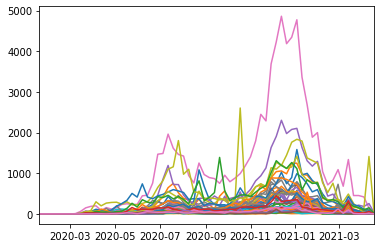

In [8]:
new_df
new_df.loc[allist].T.plot(legend=False)

In [9]:
goog_dates
stdt=goog_dates[-1].split('_')[0]
for i in range(1,60):
    dt0=(datetime.strptime(stdt,'%Y-%m-%d')+timedelta(weeks=i)).strftime('%Y-%m-%d')
    dt1=(datetime.strptime(dt0,'%Y-%m-%d')+timedelta(days=6)).strftime('%Y-%m-%d')
    goog_dates.append(dt0+'_'+dt1)

sorted(goog_dates)[-1]

'2023-11-05_2023-11-11'

In [10]:
def date_fmt_patch_folder(hrzn_dates_str):
    hrzn_dates=[]
    for dts in hrzn_dates_str:
        dt=datetime.strptime(dts,'%Y-%m-%d').date()+timedelta(days=3)
        hrzn_dates.append('{}'.format(dt.day)+dt.strftime('%b').lower())
    return hrzn_dates

def patch_file_formatter(file,goog_dates):
    ptdf=pd.read_csv(file)
    ptdf=ptdf.rename(columns={'id':'cnty'})
    ptdf['cnty']=ptdf.cnty.apply(lambda x: '{:05}'.format(x))
    ptdf=ptdf.set_index('cnty')
    st_date=datetime.strptime('2020-01-19','%Y-%m-%d').date()
    for col in ptdf.columns:
        ptdf=ptdf.rename(columns={col:st_date+timedelta(days=int(col))})

    ptdf_dates=[get_week(x.strftime('%Y-%m-%d'),goog_dates) for x in ptdf.columns]
    ptdf.columns=ptdf_dates
    ptdf=ptdf.groupby(ptdf.columns,axis=1).sum()
    for col in ptdf.columns:
        ptdf=ptdf.rename(columns={col:col.split('_')[0]})

#     for col in ptdf.columns:
#         ptdf=ptdf.rename(columns={col:datetime.strptime(col,'%Y-%m-%d').date()})
    return ptdf

In [10]:
pdir=os.listdir('/project/biocomplexity/COVID-19_commons/adaptive_modeling/output/v3/projections_dev/')
pdir=sorted(pdir)

In [11]:
stdt='2020-11-14'
dts=[]
for i in range(0,27):
    dts.append((datetime.strptime(stdt,'%Y-%m-%d')-timedelta(weeks=i)).strftime('%Y-%m-%d'))

In [8]:
ls /sfs/qumulo/qproject/biocomplexity/pjp2b/devel/adaptive_output_test/v10/projections_dev/2021-03-20/ALL/v1.8_i14/Adaptive/

Adaptive_confirmed_lb.csv
Adaptive_confirmed_lb_projection.csv
Adaptive_confirmed_lb_rescaled.csv
Adaptive_confirmed_med.csv
Adaptive_confirmed_med_projection.csv
Adaptive_confirmed_med_rescaled.csv
Adaptive_confirmed_ub.csv
Adaptive_confirmed_ub_projection.csv
Adaptive_confirmed_ub_rescaled.csv
Adaptive_death_lb.csv
Adaptive_death_lb_projection.csv
Adaptive_death_lb_rescaled.csv
Adaptive_death_med.csv
Adaptive_death_med_projection.csv
Adaptive_death_med_rescaled.csv
Adaptive_death_ub.csv
Adaptive_death_ub_projection.csv
Adaptive_death_ub_rescaled.csv
Adaptive_hospitalized_lb.csv
Adaptive_hospitalized_lb_projection.csv
Adaptive_hospitalized_lb_rescaled.csv
Adaptive_hospitalized_med.csv
Adaptive_hospitalized_med_projection.csv
Adaptive_hospitalized_med_rescaled.csv
Adaptive_hospitalized_ub.csv
Adaptive_hospitalized_ub_projection.csv
Adaptive_hospitalized_ub_rescaled.csv
Adaptive_icu_lb.csv
Adaptive_icu_lb_projection.csv
Adaptive_icu_lb_rescaled.csv
Adaptive_icu_med.csv
Adaptive_icu_med_

In [23]:
for dt in [stdt]:
    dir1='/project/biocomplexity/COVID-19_commons/adaptive_modeling/output/v4/projections_dev/{}//ALL/v1.8_i14/Adaptive/'.format(dt)
    if os.path.exists(dir1):
        print(dt+' exists')
    else:
        print(dt+' not exists')

2020-11-14 not exists


In [9]:
# hrzn_dates=['2020-10-11']#['2020-07-27','2020-08-03','2020-08-10','2020-08-17','2020-08-24','2020-08-31','2020-09-07','2020-09-12','2020-09-19','2020-09-26']
# ptch_path='/project/biocomplexity/COVID-19_commons/adaptive_modeling/output/v3/projections_dev/{}/ALL'
# for i in dts:#hrzn_dates:
#     if os.path.exists('/project/biocomplexity/COVID-19_commons/adaptive_modeling/output/v3/projections_dev/{}/ALL'.format(i)):
#         print(i)
#     else:
#         print('{}-does not have ALL'.format(i))


In [ ]:
datetime.weekday(datetime.strptime('2020-09-26','%Y-%m-%d'))

In [38]:
# Account for missing ALL/ folder and update
for dt in 
for flnm in ['Adaptive_confirmed_med.csv', 'Adaptive_confirmed_lb.csv','Adaptive_confirmed_ub.csv']:
    tempdf=pd.DataFrame()
    to_fold='/project/biocomplexity/COVID-19_commons/adaptive_modeling/output/v3/projections_dev/2020-10-11/ALL/v1.7/Adaptive/'
    to_file=to_fold+'/'+flnm
    if not os.path.exists(to_fold):
        os.makedirs(to_fold)
    for fold in sorted(os.listdir('/project/biocomplexity/COVID-19_commons/adaptive_modeling/output/v3/projections_dev/2020-10-11/')):
        if fold not in ['ALL','v1.6','v1.7','v1.8','v1.9']:
#             print(fold)
            tempdf=tempdf.append(pd.read_csv('/project/biocomplexity/COVID-19_commons/adaptive_modeling/output/v3/projections_dev/2020-10-11/{}/v1.7/Adaptive/{}'.format(fold,flnm)))
    tempdf.to_csv(to_file,index=None)

In [11]:
def get_week_dt(tdt,td):
    x=(datetime.strptime(tdt,'%Y-%m-%d')+timedelta(weeks=td)).strftime('%Y-%m-%d')
    return x

In [12]:
get_week_dt

<function __main__.get_week_dt(tdt, td)>

In [13]:
stdt='2021-04-17'

In [14]:
# hrzn_dates=['2020-10-11']#['2020-07-27','2020-08-03','2020-08-10','2020-08-17','2020-08-24','2020-08-31','2020-09-07','2020-09-12','2020-09-19','2020-09-26']
outdir='/project/biocomplexity/aniadiga/covid-19_forecast/output/PatchSim/'
# hrzn_dates=date_fmt_patch_folder(hrzn_dates_str)
# rebound=['BestFit']#['LightRebound', 'StrongRebound','BestFit']
meth='PatchSim_adpt'
for hrzn in tqdm([stdt]):#tqdm(dts):#tqdm(hrzn_dates):
    print(hrzn)
    cntyresdf=pd.DataFrame(columns=['method','fips','fct_date','horizon','avl_date','value','fct_std','fct_lb','fct_ub'],index=None)
    pth='/sfs/qumulo/qproject/biocomplexity/pjp2b/devel/adaptive_output_test/v10/projections_dev/{}/ALL/v1.8_i14/Adaptive/'.format(hrzn)
    if not os.path.exists(pth):
        print('{} not exists'.format(hrzn))
        continue
    else:
    #     hrzn_short=date_fmt_patch_folder([hrzn])[0]
    #     for reb in rebound:
    #         pth=ptch_path+'{}/{}/'.format(hrzn_short,reb)
    #         if os.path.isdir(pth):
    #             print(pth)
        name='Adaptive_confirmed_med.csv'
        name_lb='Adaptive_confirmed_lb.csv'
        name_ub='Adaptive_confirmed_ub.csv' 
        file=pth+name
    #         if os.path.isfile(file):
    #             print(file)
    #         if not os.path.isfile(file):
    #             file=pth+'{}_MAAPE_50_confirmed_med.csv'.format(reb)
        file_lb=pth+name_lb
    #         if not os.path.isfile(file_lb):
    #             file_lb=pth+'{}_MAAPE_50_confirmed_lb.csv'.format(reb)
        file_ub=pth+name_ub
    #         if not os.path.isfile(file_ub):
    #             file_ub=pth+'{}_MAAPE_50_confirmed_ub.csv'.format(reb)
    #         print(file)
        try:
            ptdf=patch_file_formatter(file,goog_dates)
            ptdf_ub=patch_file_formatter(file_ub,goog_dates)
            ptdf_lb=patch_file_formatter(file_lb,goog_dates)
        except:
            print('some issue')
            break
    #         pdb.set_trace()
    # #             continue
    #         # hrzn_dates=[datetime.strptime(x,'%Y-%m-%d').date() for x in hrzn_dates_str]
    #         hrzn_date=datetime.strptime(hrzn,'%Y-%m-%d').date()
    #         # patch_hrzn_dates=datetime.strptime(hrzn_dates[0],'%Y-%m-%d').date().strftime('%d%B')[0:5].lower()
    #         # patch_hrzn_dates=[(x+timedelta(days=3)).strftime('%d%B')[0:5].lower() for x in hrzn_dates]

        resdf=pd.DataFrame(columns=['method','fips','fct_date','horizon','avl_date','fct_std','fct_lb','fct_ub'],index=None)
    #         # hrzn=hrzn_dates[1]
    #         if reb=='LightRebound':
    #             meth='patchsim_LR'
    #         elif reb=='StrongRebound':
    #             meth='patchsim_SR'
    #         elif reb=='BestFit':
    #             meth='patchsim_BF'
        wkday=datetime.weekday(datetime.strptime(hrzn,'%Y-%m-%d'))
        if wkday==0:
            wkday=7
        hrzn_dt=(datetime.strptime(hrzn,'%Y-%m-%d')-timedelta(days=wkday+1)).strftime('%Y-%m-%d')
        sub_dt=(datetime.strptime(hrzn_dt,'%Y-%m-%d')+timedelta(days=8)).strftime('%Y%m%d')
        for cnty_name in ptdf.index:
            for mul_step  in range(1,5):
                try:
                    fct_week=get_week_dt(hrzn_dt,mul_step)
                    resdf.loc[0,'fct_mean']=ptdf.loc[cnty_name,fct_week]

                    resdf.loc[0,'method']=meth
                    resdf.loc[0,'fips']=cnty_name
                    resdf.loc[0,'avl_date']=hrzn_dt
                    resdf.loc[0,'fct_date']=fct_week
                    resdf.loc[0,'fct_lb']=ptdf_lb.loc[cnty_name,fct_week]
                    resdf.loc[0,'fct_ub']=ptdf_ub.loc[cnty_name,fct_week]
                    resdf.loc[0,'fct_std']=(resdf.loc[0,'fct_ub']-resdf.loc[0,'fct_mean'])/1.96
                    resdf.loc[0,'horizon']=mul_step
                    cntyresdf=cntyresdf.append(resdf,ignore_index=True)
                except Exception as e: 
                    print(e)
                    pdb.set_trace()

        cntyresdf.to_csv(outdir+'PatchSim_adpt_{}.csv'.format(sub_dt),index=None)
    #                 resdf.loc[0,'iter']=0
    #                 resdf.loc[0,'train_mape']=0
    #                 resdf.loc[0,'train_mse']=0
    #                 try:
    #                     resdf.loc[0,'true']=new_df.loc[cnty_name,fct_week]
    #                     resdf.loc[0,'fct_mape']=get_mape(ptdf.loc[cnty_name,fct_week],new_df.loc[cnty_name,fct_week])
    #                 except:
    #                     resdf.loc[0,'true']=np.nan
    #                     resdf.loc[0,'fct_mape']=np.nan
    #             except:
    #                 fct_week
    #                 continue

    # #                 cntyresdf=cntyresdf.append(resdf,ignore_index=True)

2021-04-17


/home/aa5dw/.local/lib/python3.6/site-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [15]:
idir='/sfs/qumulo/qproject/biocomplexity/aniadiga/covid-19_forecast/output/PatchSim/'
date_list=[]
for f in os.listdir(idir):
#     print(f)
    date_list.append((f.split('_')[2]).split('.')[0])
date_list=sorted(date_list)
date_list=date_list[::-1]

psdf=pd.DataFrame()
for f in date_list:#['20200921','20200914','20200906']:
    psdf=psdf.append(pd.read_csv(idir+'PatchSim_adpt_{}.csv'.format(f),dtype={'fips':str,'value':float,'fct_std':float}))

psdf.fips=psdf.fips.apply(lambda x: '{:05}'.format(int(x)))
psdf['step_ahead']=psdf.horizon.apply(lambda x: '{}-step_ahead'.format(x))
psdf=psdf.drop(['horizon','value'],axis=1)

psdf=psdf.rename(columns={'fips':'cnty','ground':'true','avl_date':'horizon'})

# imadf['fct_lb']=imadf['fct_mean']-1.96*imadf['fct_std']
# imadf['fct_ub']=imadf['fct_mean']+1.96*imadf['fct_std']
psdf['method']='PatchSim_adpt'



PatchSim_adpt_20200810.csv
PatchSim_adpt_20200713.csv
PatchSim_adpt_20201123.csv
PatchSim_adpt_20200518.csv
PatchSim_adpt_20210322.csv
PatchSim_adpt_20200504.csv
PatchSim_adpt_20201207.csv
PatchSim_adpt_20200413.csv
PatchSim_adpt_20210301.csv
PatchSim_adpt_20210329.csv
PatchSim_adpt_20210125.csv
PatchSim_adpt_20200907.csv
PatchSim_adpt_20210222.csv
PatchSim_adpt_20201130.csv
PatchSim_adpt_20200427.csv
PatchSim_adpt_20201214.csv
PatchSim_adpt_20200727.csv
PatchSim_adpt_20200817.csv
PatchSim_adpt_20200601.csv
PatchSim_adpt_20210308.csv
PatchSim_adpt_20201012.csv
PatchSim_adpt_20201102.csv
PatchSim_adpt_20210104.csv
PatchSim_adpt_20210419.csv
PatchSim_adpt_20210201.csv
PatchSim_adpt_20200622.csv
PatchSim_adpt_20200706.csv
PatchSim_adpt_20200921.csv
PatchSim_adpt_20200511.csv
PatchSim_adpt_20210315.csv
PatchSim_adpt_20200720.csv
PatchSim_adpt_20210118.csv
PatchSim_adpt_20201026.csv
PatchSim_adpt_20201116.csv
PatchSim_adpt_20200615.csv
PatchSim_adpt_20200420.csv
PatchSim_adpt_20200629.csv
P

In [18]:
max(sorted(psdf.horizon.unique()))

'2021-04-11'

In [17]:
psdf.to_csv('/project/biocomplexity/aniadiga/Forecasting/covid19_ensemble/output/methods/PatchSim//merged.csv',index=None)

In [79]:
bdf=pd.read_csv('/sfs/qumulo/qproject/biocomplexity/pjp2b/devel/adaptive_SEIR/output_ensemble/v10_ensemble/projections_dev/2021-03-27/ALL/v1.8_i14/Adaptive-VariantB117/Adaptive-VariantB117_confirmed_med.csv',dtype={'id':str})

In [19]:
# hrzn_dates=['2020-10-11']#['2020-07-27','2020-08-03','2020-08-10','2020-08-17','2020-08-24','2020-08-31','2020-09-07','2020-09-12','2020-09-19','2020-09-26']
outdir='/project/biocomplexity/aniadiga/covid-19_forecast/output/PatchSim_B117/'
if not os.path.exists(outdir):
    os.makedirs(outdir)
# hrzn_dates=date_fmt_patch_folder(hrzn_dates_str)
# rebound=['BestFit']#['LightRebound', 'StrongRebound','BestFit']
meth='PatchSim_adpt-B117'
for hrzn in tqdm([stdt]):#tqdm(dts):#tqdm(hrzn_dates):
    print(hrzn)
    cntyresdf=pd.DataFrame(columns=['method','fips','fct_date','horizon','avl_date','value','fct_std','fct_lb','fct_ub'],index=None)
    pth='/sfs/qumulo/qproject/biocomplexity/pjp2b/devel/adaptive_SEIR/output_ensemble/v10/projections_dev/{}/ALL/v1.8_i14/Adaptive-VariantB117/'.format(hrzn)
    if not os.path.exists(pth):
        print('{} not exists'.format(hrzn))
        continue
    else:
    #     hrzn_short=date_fmt_patch_folder([hrzn])[0]
    #     for reb in rebound:
    #         pth=ptch_path+'{}/{}/'.format(hrzn_short,reb)
    #         if os.path.isdir(pth):
    #             print(pth)
        name='Adaptive-VariantB117_confirmed_med.csv'
        name_lb='Adaptive-VariantB117_confirmed_lb.csv'
        name_ub='Adaptive-VariantB117_confirmed_ub.csv' 
        file=pth+name
    #         if os.path.isfile(file):
    #             print(file)
    #         if not os.path.isfile(file):
    #             file=pth+'{}_MAAPE_50_confirmed_med.csv'.format(reb)
        file_lb=pth+name_lb
    #         if not os.path.isfile(file_lb):
    #             file_lb=pth+'{}_MAAPE_50_confirmed_lb.csv'.format(reb)
        file_ub=pth+name_ub
    #         if not os.path.isfile(file_ub):
    #             file_ub=pth+'{}_MAAPE_50_confirmed_ub.csv'.format(reb)
    #         print(file)
        try:
            ptdf=patch_file_formatter(file,goog_dates)
            ptdf_ub=patch_file_formatter(file_ub,goog_dates)
            ptdf_lb=patch_file_formatter(file_lb,goog_dates)
        except:
            print('some issue')
            break
    #         pdb.set_trace()
    # #             continue
    #         # hrzn_dates=[datetime.strptime(x,'%Y-%m-%d').date() for x in hrzn_dates_str]
    #         hrzn_date=datetime.strptime(hrzn,'%Y-%m-%d').date()
    #         # patch_hrzn_dates=datetime.strptime(hrzn_dates[0],'%Y-%m-%d').date().strftime('%d%B')[0:5].lower()
    #         # patch_hrzn_dates=[(x+timedelta(days=3)).strftime('%d%B')[0:5].lower() for x in hrzn_dates]

        resdf=pd.DataFrame(columns=['method','fips','fct_date','horizon','avl_date','fct_std','fct_lb','fct_ub'],index=None)
    #         # hrzn=hrzn_dates[1]
    #         if reb=='LightRebound':
    #             meth='patchsim_LR'
    #         elif reb=='StrongRebound':
    #             meth='patchsim_SR'
    #         elif reb=='BestFit':
    #             meth='patchsim_BF'
        wkday=datetime.weekday(datetime.strptime(hrzn,'%Y-%m-%d'))
        if wkday==0:
            wkday=7
        hrzn_dt=(datetime.strptime(hrzn,'%Y-%m-%d')-timedelta(days=wkday+1)).strftime('%Y-%m-%d')
        sub_dt=(datetime.strptime(hrzn_dt,'%Y-%m-%d')+timedelta(days=8)).strftime('%Y%m%d')
        for cnty_name in ptdf.index:
            for mul_step  in range(1,5):
                try:
                    fct_week=get_week_dt(hrzn_dt,mul_step)
                    resdf.loc[0,'fct_mean']=ptdf.loc[cnty_name,fct_week]

                    resdf.loc[0,'method']=meth
                    resdf.loc[0,'fips']=cnty_name
                    resdf.loc[0,'avl_date']=hrzn_dt
                    resdf.loc[0,'fct_date']=fct_week
                    resdf.loc[0,'fct_lb']=ptdf_lb.loc[cnty_name,fct_week]
                    resdf.loc[0,'fct_ub']=ptdf_ub.loc[cnty_name,fct_week]
                    resdf.loc[0,'fct_std']=(resdf.loc[0,'fct_ub']-resdf.loc[0,'fct_mean'])/1.96
                    resdf.loc[0,'horizon']=mul_step
                    cntyresdf=cntyresdf.append(resdf,ignore_index=True)
                except Exception as e: 
                    print(e)
                    pdb.set_trace()

        cntyresdf.to_csv(outdir+'PatchSim_adpt-B117_{}.csv'.format(sub_dt),index=None)
    #                 resdf.loc[0,'iter']=0
    #                 resdf.loc[0,'train_mape']=0
    #                 resdf.loc[0,'train_mse']=0
    #                 try:
    #                     resdf.loc[0,'true']=new_df.loc[cnty_name,fct_week]
    #                     resdf.loc[0,'fct_mape']=get_mape(ptdf.loc[cnty_name,fct_week],new_df.loc[cnty_name,fct_week])
    #                 except:
    #                     resdf.loc[0,'true']=np.nan
    #                     resdf.loc[0,'fct_mape']=np.nan
    #             except:
    #                 fct_week
    #                 continue

    # #                 cntyresdf=cntyresdf.append(resdf,ignore_index=True)

2021-04-17



In [20]:
idir='/sfs/qumulo/qproject/biocomplexity/aniadiga/covid-19_forecast/output/PatchSim_B117/'
date_list=[]
for f in os.listdir(idir):
    print(f)
    date_list.append((f.split('_')[2]).split('.')[0])
date_list=sorted(date_list)
date_list=date_list[::-1]

psdf=pd.DataFrame()
for f in date_list:#['20200921','20200914','20200906']:
    psdf=psdf.append(pd.read_csv(idir+'PatchSim_adpt-B117_{}.csv'.format(f),dtype={'fips':str,'value':float,'fct_std':float}))

psdf.fips=psdf.fips.apply(lambda x: '{:05}'.format(int(x)))
psdf['step_ahead']=psdf.horizon.apply(lambda x: '{}-step_ahead'.format(x))
psdf=psdf.drop(['horizon','value'],axis=1)

psdf=psdf.rename(columns={'fips':'cnty','ground':'true','avl_date':'horizon'})

# imadf['fct_lb']=imadf['fct_mean']-1.96*imadf['fct_std']
# imadf['fct_ub']=imadf['fct_mean']+1.96*imadf['fct_std']
psdf['method']='PatchSim_adpt-B117'

PatchSim_adpt-B117_20210315.csv
PatchSim_adpt-B117_20210412.csv
PatchSim_adpt-B117_20210405.csv
PatchSim_adpt-B117_20210322.csv
PatchSim_adpt-B117_20210329.csv
PatchSim_adpt-B117_20210419.csv


In [21]:
# os.makedirs('/project/biocomplexity/aniadiga/Forecasting/covid19_ensemble/output/methods/PatchSim_B117/')
psdf.to_csv('/project/biocomplexity/aniadiga/Forecasting/covid19_ensemble/output/methods/PatchSim_B117//merged.csv',index=None)

In [15]:
# tdf.loc[:,'fct_mean']=pd.to_numeric(tdf['fct_mean'],errors='coerce')
# tdf.loc[:,'fct_std']=pd.to_numeric(tdf['fct_std'],errors='coerce')

In [16]:
# ptdf.loc[:,(ptdf.columns>=hrzn_dates[0])&(ptdf.columns<=hrzn_dates[0]+timedelta(weeks=4))]

In [13]:
tdf.loc[:,'fct_ub']=tdf['fct_mean']+1.96*tdf['fct_std']/np.sqrt(1000)
tdf.loc[:,'fct_lb']=tdf['fct_mean']-1.96*tdf['fct_std']/np.sqrt(1000)

In [14]:
# for cn in tqdm(tdf.cnty.unique()):
#     for dt in tdf.fct_date.unique():
#         for mtd in tdf.method.unique():
#             ind=tdf[(tdf.cnty==cn)&(tdf.fct_date==dt)&(tdf.method==mtd)].index
#             try:
#                 tdf.loc[ind,'true']=new_df.loc[cn,dt]
#                 tdf.loc[ind,'fct_mape']=get_mape(tdf.loc[ind,'fct_mean'],tdf.loc[ind,'true'])
#             except:
#                 continue

In [32]:
tdf['fct_date'].unique()[0]

'2020-05-24'

In [70]:
cntyresdf=cntyresdf.append(tdf,ignore_index=None)

In [27]:
# cntyresdf[cntyresdf.method=='spatial']

In [26]:
cntyresdf[(cntyresdf.method=='patchsim_BF')&(cntyresdf.horizon==datetime.strptime('2020-07-12','%Y-%m-%d').date())].step_ahead.unique()

array(['1-step_ahead', '2-step_ahead', '3-step_ahead'], dtype=object)

In [93]:
b117_methods=os.listdir('/project/biocomplexity/pjp2b/devel/adaptive_SEIR/output_ensemble/v10_comparative/projections_dev/2021-04-03/ALL/v1.8_i14/')
b117_dates=os.listdir('/project/biocomplexity/pjp2b/devel/adaptive_SEIR/output_ensemble/v10_comparative/projections_dev/')

In [105]:
# hrzn_dates=['2020-10-11']#['2020-07-27','2020-08-03','2020-08-10','2020-08-17','2020-08-24','2020-08-31','2020-09-07','2020-09-12','2020-09-19','2020-09-26']
for mtd in b117_methods:
    outdir='/project/biocomplexity/aniadiga/covid-19_forecast/output_comp/{}/'.format(mtd)
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    # hrzn_dates=date_fmt_patch_folder(hrzn_dates_str)
    # rebound=['BestFit']#['LightRebound', 'StrongRebound','BestFit']
    meth=mtd
    print(mtd)
    for hrzn in tqdm(b117_dates):#tqdm(dts):#tqdm(hrzn_dates):
        print(hrzn)
        cntyresdf=pd.DataFrame(columns=['method','fips','fct_date','horizon','avl_date','value','fct_std','fct_lb','fct_ub'],index=None)
        pth='/project/biocomplexity/pjp2b/devel/adaptive_SEIR/output_ensemble/v10_comparative/projections_dev/{}/ALL/v1.8_i14/{}/'.format(hrzn,mtd)
        if not os.path.exists(pth):
            print('{} not exists'.format(hrzn))
            continue
        else:
        #     hrzn_short=date_fmt_patch_folder([hrzn])[0]
        #     for reb in rebound:
        #         pth=ptch_path+'{}/{}/'.format(hrzn_short,reb)
        #         if os.path.isdir(pth):
        #             print(pth)
            name='{}_confirmed_med.csv'.format(mtd)
            name_lb='{}_confirmed_lb.csv'.format(mtd)
            name_ub='{}_confirmed_ub.csv'.format(mtd) 
            file=pth+name
        #         if os.path.isfile(file):
        #             print(file)
        #         if not os.path.isfile(file):
        #             file=pth+'{}_MAAPE_50_confirmed_med.csv'.format(reb)
            file_lb=pth+name_lb
        #         if not os.path.isfile(file_lb):
        #             file_lb=pth+'{}_MAAPE_50_confirmed_lb.csv'.format(reb)
            file_ub=pth+name_ub
        #         if not os.path.isfile(file_ub):
        #             file_ub=pth+'{}_MAAPE_50_confirmed_ub.csv'.format(reb)
        #         print(file)
            try:
                ptdf=patch_file_formatter(file,goog_dates)
                ptdf_ub=patch_file_formatter(file_ub,goog_dates)
                ptdf_lb=patch_file_formatter(file_lb,goog_dates)
            except:
                print('some issue')
                break
        #         pdb.set_trace()
        # #             continue
        #         # hrzn_dates=[datetime.strptime(x,'%Y-%m-%d').date() for x in hrzn_dates_str]
        #         hrzn_date=datetime.strptime(hrzn,'%Y-%m-%d').date()
        #         # patch_hrzn_dates=datetime.strptime(hrzn_dates[0],'%Y-%m-%d').date().strftime('%d%B')[0:5].lower()
        #         # patch_hrzn_dates=[(x+timedelta(days=3)).strftime('%d%B')[0:5].lower() for x in hrzn_dates]

            resdf=pd.DataFrame(columns=['method','fips','fct_date','horizon','avl_date','fct_std','fct_lb','fct_ub'],index=None)
        #         # hrzn=hrzn_dates[1]
        #         if reb=='LightRebound':
        #             meth='patchsim_LR'
        #         elif reb=='StrongRebound':
        #             meth='patchsim_SR'
        #         elif reb=='BestFit':
        #             meth='patchsim_BF'
            wkday=datetime.weekday(datetime.strptime(hrzn,'%Y-%m-%d'))
            if wkday==0:
                wkday=7
            hrzn_dt=(datetime.strptime(hrzn,'%Y-%m-%d')-timedelta(days=wkday+1)).strftime('%Y-%m-%d')
            sub_dt=(datetime.strptime(hrzn_dt,'%Y-%m-%d')+timedelta(days=8)).strftime('%Y%m%d')
            for cnty_name in ptdf.index:
                for mul_step  in range(1,5):
                    try:
                        fct_week=get_week_dt(hrzn_dt,mul_step)
                        resdf.loc[0,'fct_mean']=ptdf.loc[cnty_name,fct_week]

                        resdf.loc[0,'method']=meth
                        resdf.loc[0,'fips']=cnty_name
                        resdf.loc[0,'avl_date']=hrzn_dt
                        resdf.loc[0,'fct_date']=fct_week
                        resdf.loc[0,'fct_lb']=ptdf_lb.loc[cnty_name,fct_week]
                        resdf.loc[0,'fct_ub']=ptdf_ub.loc[cnty_name,fct_week]
                        resdf.loc[0,'fct_std']=(resdf.loc[0,'fct_ub']-resdf.loc[0,'fct_mean'])/1.96
                        resdf.loc[0,'horizon']=mul_step
                        cntyresdf=cntyresdf.append(resdf,ignore_index=True)
                    except Exception as e: 
                        print(e)
                        pdb.set_trace()

            cntyresdf.to_csv(outdir+'{}_{}.csv'.format(mtd,sub_dt),index=None)
        #                 resdf.loc[0,'iter']=0
        #                 resdf.loc[0,'train_mape']=0
        #                 resdf.loc[0,'train_mse']=0
        #                 try:
        #                     resdf.loc[0,'true']=new_df.loc[cnty_name,fct_week]
        #                     resdf.loc[0,'fct_mape']=get_mape(ptdf.loc[cnty_name,fct_week],new_df.loc[cnty_name,fct_week])
        #                 except:
        #                     resdf.loc[0,'true']=np.nan
        #                     resdf.loc[0,'fct_mape']=np.nan
        #             except:
        #                 fct_week
        #                 continue

        # #                 cntyresdf=cntyresdf.append(resdf,ignore_index=True)

Adaptive-FatigueControlSummer-VariantB117


2021-03-13


/home/aa5dw/.local/lib/python3.6/site-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


2021-03-06
2021-04-03
2021-03-20
2021-03-27

Adaptive-VariantB117@-14


2021-03-13
2021-03-06
2021-04-03
2021-03-20
2021-03-27

Adaptive-VariantB117@+14


2021-03-13
2021-03-06
2021-04-03
2021-03-20
2021-03-27

Adaptive-VariantB117


2021-03-13
2021-03-06
2021-04-03
2021-03-20
2021-03-27

Adaptive-FatigueControl-VariantB117


2021-03-13
2021-03-06
2021-04-03
2021-03-20
2021-03-27

Adaptive-VariantB117@-7


2021-03-13
2021-03-06
2021-04-03
2021-03-20
2021-03-27

Adaptive-VariantB117@+7


2021-03-13
2021-03-06
2021-04-03
2021-03-20
2021-03-27



In [109]:
for mtd in b117_methods:
    idir='/sfs/qumulo/qproject/biocomplexity/aniadiga/covid-19_forecast/output_comp//{}/'.format(mtd)
    mr_outdir='/project/biocomplexity/aniadiga/Forecasting/covid19_ensemble/output/methods/{}/'.format(mtd)
    if not os.path.exists(mr_outdir):
        os.makedirs(mr_outdir)
    date_list=[]
    for f in os.listdir(idir):
        print(f)
        date_list.append((f.split('_')[1]).split('.')[0])
    date_list=sorted(date_list)
    date_list=date_list[::-1]

    psdf=pd.DataFrame()
    for f in date_list:#['20200921','20200914','20200906']:
        psdf=psdf.append(pd.read_csv(idir+'{}_{}.csv'.format(mtd,f),dtype={'fips':str,'value':float,'fct_std':float}))

    psdf.fips=psdf.fips.apply(lambda x: '{:05}'.format(int(x)))
    psdf['step_ahead']=psdf.horizon.apply(lambda x: '{}-step_ahead'.format(x))
    psdf=psdf.drop(['horizon','value'],axis=1)

    psdf=psdf.rename(columns={'fips':'cnty','ground':'true','avl_date':'horizon'})

# imadf['fct_lb']=imadf['fct_mean']-1.96*imadf['fct_std']
# imadf['fct_ub']=imadf['fct_mean']+1.96*imadf['fct_std']
    psdf['method']=mtd
    psdf.to_csv(mr_outdir+'merged.csv',index=None)

Adaptive-FatigueControlSummer-VariantB117_20210315.csv
Adaptive-FatigueControlSummer-VariantB117_20210329.csv
Adaptive-FatigueControlSummer-VariantB117_20210405.csv
Adaptive-FatigueControlSummer-VariantB117_20210322.csv
Adaptive-FatigueControlSummer-VariantB117_20210308.csv
Adaptive-VariantB117@-14_20210322.csv
Adaptive-VariantB117@-14_20210329.csv
Adaptive-VariantB117@-14_20210405.csv
Adaptive-VariantB117@-14_20210308.csv
Adaptive-VariantB117@-14_20210315.csv
Adaptive-VariantB117@+14_20210322.csv
Adaptive-VariantB117@+14_20210405.csv
Adaptive-VariantB117@+14_20210315.csv
Adaptive-VariantB117@+14_20210308.csv
Adaptive-VariantB117@+14_20210329.csv
Adaptive-VariantB117_20210329.csv
Adaptive-VariantB117_20210308.csv
Adaptive-VariantB117_20210315.csv
Adaptive-VariantB117_20210405.csv
Adaptive-VariantB117_20210322.csv
Adaptive-FatigueControl-VariantB117_20210315.csv
Adaptive-FatigueControl-VariantB117_20210329.csv
Adaptive-FatigueControl-VariantB117_20210405.csv
Adaptive-FatigueControl-Vari

In [113]:
pd.read_csv('/project/biocomplexity/aniadiga/data_dump/wts_b117_variants_all_scenarios.csv')

,cnty,horizon,method,sig,step_ahead,wts
0,1001,2021-03-28,Adaptive-FatigueControl-VariantB117,0.000000,1-step_ahead,0.000000
1,1001,2021-03-28,Adaptive-FatigueControlSummer-VariantB117,0.000000,1-step_ahead,0.000000
2,1001,2021-03-28,Adaptive-VariantB117,0.000000,1-step_ahead,0.000000
3,1001,2021-03-28,Adaptive-VariantB117@+14,0.000000,1-step_ahead,0.000000
4,1001,2021-03-28,Adaptive-VariantB117@+7,0.000000,1-step_ahead,0.000000
5,1001,2021-03-28,Adaptive-VariantB117@-14,46.690156,1-step_ahead,0.498063
6,1001,2021-03-28,Adaptive-VariantB117@-7,46.807935,1-step_ahead,0.501937
7,1001,2021-03-28,Adaptive-FatigueControl-VariantB117,69.329523,2-step_ahead,0.352617
8,1001,2021-03-28,Adaptive-FatigueControlSummer-VariantB117,0.000000,2-step_ahead,0.000000
9,1001,2021-03-28,Adaptive-VariantB117,0.000000,2-step_ahead,0.000000


### lstm

In [22]:
fold='/project/biocomplexity/aniadiga/covid-19_forecast/output/LSTM/'
lsdf1=pd.read_csv(fold+'lstm-prediction-retro.csv',dtype={'fips':str,'value':float,'fct_std':float})
cols=lsdf1.columns

In [23]:
lsdf=pd.DataFrame()

In [24]:
# dts1=[(datetime.strptime(x,'%Y-%m-%d')+timedelta(days=1)).strftime('%Y%m%d') for x in dts]


In [25]:
dt_lstm=[]
for sfl in os.listdir(fold):
    fl=os.path.splitext(sfl)[0]
    if fl.split('-')[2]=='mf' or fl.split('-')[2]=='retro' or fl.split('-')[1]=='Virginia':
        continue
        
    else:
        dt_lstm.append(fl.split('-')[2])
#         lsdf=lsdf.append(pd.read_csv(fold+sfl,names=cols),ignore_index=True)
        

In [26]:
dtfin=sorted(dt_lstm)[-1]
dtfin

'20210419'

In [27]:
lsdf=pd.read_csv(fold+'lstm-prediction-{}.csv'.format(dtfin),header=None)

In [28]:
# for fl in ['20201207']:#['20200720','20200727','20200803','20200810','20200817','20200831','20200914','20200921','20200928','20201005','20201012']:
#     try:
#         lsdf=lsdf.append(pd.read_csv(fold+'lstm-prediction-{}.csv'.format(fl),header=None))
#     except:
#         print("{} not found".format(fl))

In [29]:
lsdf.columns=cols

In [30]:
# lsdf=lsdf.append(pd.read_csv(fold+'/lstm-prediction-mf-retro.csv'))

In [31]:
# lsdf.loc[:,'fct_date']=lsdf.fct_date.apply(lambda x: (datetime.strptime(x,'%Y-%m-%d')+timedelta(weeks=1)).strftime('%Y-%m-%d'))

In [32]:
# lsdf[lsdf.cnty=='02158']

In [33]:
lsdf=lsdf[lsdf.horizon!='horizon']
lsdf[lsdf.horizon=='horizon']

/home/aa5dw/.local/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


,fips,fct_date,horizon,avl_date,value,fct_std


In [34]:
import math
lsdf=lsdf[lsdf.horizon.isin([0,1,2,3])]
lsdf.horizon=lsdf.horizon.astype(str).astype(float).astype(int)

In [35]:
lsdf.horizon.unique()

array([0, 1, 2, 3])

In [36]:
# lsdf.fct_lb=lsdf.fct_lb.astype(float)
# lsdf.fct_ub=lsdf.fct_ub.astype(float)

In [37]:
# lsdf=lsdf[lsdf.horizon=='horizon']

In [38]:
# sorted(lsdf.avl_date.unique())
# lsdf['fct_date']=(pd.to_datetime(lsdf['avl_date'], format='%Y-%m-%d')+ pd.to_timedelta(lsdf['horizon']+1,unit='W')).dt.strftime('%Y-%m-%d')

In [39]:
lsdf['horizon']=lsdf.horizon.astype(float).astype(int)
lsdf['step_ahead']=lsdf.horizon.apply(lambda x: '{}-step_ahead'.format(x+1))
lsdf=lsdf.drop(['horizon'],axis=1)
lsdf=lsdf.rename(columns={'value':'fct_mean','fips':'cnty','ground':'true','avl_date':'horizon'})
lsdf.fct_mean=lsdf.fct_mean.astype(float)
lsdf.fct_std=lsdf.fct_std.astype(float)
lsdf['fct_lb']=lsdf['fct_mean']-1.96*lsdf['fct_std']/np.sqrt(50)
lsdf['fct_ub']=lsdf['fct_mean']+1.96*lsdf['fct_std']/np.sqrt(50)
lsdf['method']='lstm'

In [40]:
# pd.read_csv('/project/biocomplexity/aniadiga/covid-19_forecast/output/LSTM/lstm-prediction-20200810.csv')


In [41]:
# lsdf=
lsdf[lsdf[['cnty','horizon','step_ahead']].duplicated()]

,cnty,fct_date,horizon,fct_mean,fct_std,step_ahead,fct_lb,fct_ub,method


In [42]:
date_list=sorted(lsdf.horizon.unique())

In [43]:
# olsdf=olsdf[olsdf.horizon<='2020-11-22']

In [44]:
olsdf=pd.read_csv('/project/biocomplexity/aniadiga/Forecasting/covid19_ensemble/output/methods/lstm/merged.csv')

In [45]:
# lsdf.cnty=lsdf.cnty.apply(lambda x: '{:05}'.format(int(x)))
olsdf.cnty=olsdf.cnty.apply(lambda x: '{:05}'.format(int(x)))

In [46]:
lstm_cn_list=olsdf.cnty.unique()

In [47]:
lsdf=lsdf[lsdf.cnty.isin(lstm_cn_list)]

In [48]:
lsdf=lsdf.append(olsdf)

In [49]:
# olsdf[olsdf[['cnty','fct_date','horizon','method','step_ahead']].duplicated()]#.horizon.unique()
# olsdf=olsdf[~olsdf[['cnty','fct_date','horizon','method','step_ahead']].duplicated()]

In [50]:
lsdf.to_csv('/project/biocomplexity/aniadiga/Forecasting/covid19_ensemble/output/methods/lstm/merged.csv',index=None)

In [51]:
# tlsdf=pd.read_csv('/project/biocomplexity/aniadiga/Forecasting/covid19_ensemble/output/methods/lstm/merged.csv')

In [52]:
# cntyresdf=cntyresdf.append(lsdf,ignore_index=None)

In [13]:
ladir='/project/biocomplexity/aniadiga/covid-19_forecast/output/LSTM_ensemble/'
ladf=pd.DataFrame()
for f in os.listdir(ladir):
    ladf=ladf.append(pd.read_csv(ladir+f,header=None, names=cols))

In [14]:
ladf.fips=ladf.fips.apply(lambda x: '{:05}'.format(x))

In [15]:
ladf['horizon']=ladf.horizon.astype(float).astype(int)
ladf['step_ahead']=ladf.horizon.apply(lambda x: '{}-step_ahead'.format(x+1))
ladf=ladf.drop(['horizon'],axis=1)
ladf=ladf.rename(columns={'value':'fct_mean','fips':'cnty','ground':'true','avl_date':'horizon'})
ladf.fct_mean=ladf.fct_mean.astype(float)
ladf.fct_std=ladf.fct_std.astype(float)
ladf['fct_lb']=ladf['fct_mean']-1.96*ladf['fct_std']
ladf['fct_ub']=ladf['fct_mean']+1.96*ladf['fct_std']
ladf['method']='lstm_ensemble'

In [16]:
os.makedirs('/project/biocomplexity/aniadiga/Forecasting/covid19_ensemble/output/methods/lstm_ensemble/')

In [17]:
ladf.to_csv('/project/biocomplexity/aniadiga/Forecasting/covid19_ensemble/output/methods/lstm_ensemble//merged.csv',index=None)

### LSTM-snapshot learning

In [42]:
fold='/project/biocomplexity/aniadiga/covid-19_forecast/output/LSTM_snapshot/'

In [43]:
sslsdf=pd.DataFrame()

In [44]:
for fl in os.listdir(fold):
    print(fl)
    sslsdf=sslsdf.append(pd.read_csv(fold+fl,names=cols),sort=True)

LSTM_snapshot-2020-08-02.csv
LSTM_snapshot-2020-08-16.csv
LSTM_snapshot-2020-11-15.csv
LSTM_snapshot-2020-08-23.csv
LSTM_snapshot-2020-11-01.csv
LSTM_snapshot-2020-10-11.csv
LSTM_snapshot-2020-10-04.csv
LSTM_snapshot-2020-08-09.csv
LSTM_snapshot-2020-09-06.cs
LSTM_snapshot-2020-09-13.csv
LSTM_snapshot-2020-09-27.csv
LSTM_snapshot-2020-09-20.csv
LSTM_snapshot-2020-10-25.csv
LSTM_snapshot-2020-10-18.csv
LSTM_snapshot-2020-11-08.csv
LSTM_snapshot-2020-11-22.csv


In [45]:
sslsdf['fips']=sslsdf.fips.apply(lambda x: '{:05}'.format(x))

In [46]:
sslsdf['horizon']=sslsdf.horizon.astype(float).astype(int)
sslsdf['step_ahead']=sslsdf.horizon.apply(lambda x: '{}-step_ahead'.format(x+1))
sslsdf=sslsdf.drop(['horizon'],axis=1)
sslsdf=sslsdf.rename(columns={'value':'fct_mean','fips':'cnty','ground':'true','avl_date':'horizon'})
sslsdf.fct_mean=sslsdf.fct_mean.astype(float)
sslsdf.fct_std=sslsdf.fct_std.astype(float)
sslsdf['fct_lb']=sslsdf['fct_mean']-1.96*sslsdf['fct_std']
sslsdf['fct_ub']=sslsdf['fct_mean']+1.96*sslsdf['fct_std']
sslsdf.loc[:,'method']='lstm_ssl'

In [47]:
outdir='/project/biocomplexity/aniadiga/Forecasting/covid19_ensemble/output/methods/lstm_snapshot/'
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [80]:
sslsdf.to_csv('/project/biocomplexity/aniadiga/Forecasting/covid19_ensemble/output/methods/lstm_snapshot/merged.csv',index=None)

In [110]:
fold='/project/biocomplexity/aniadiga/covid-19_forecast/output/causalgnn/'
cgdf=pd.DataFrame()
for fl in os.listdir(fold):
    print(fl)
    cgdf=cgdf.append(pd.read_csv(fold+fl,names=cols),sort=True)

cgdf['fips']=cgdf.fips.apply(lambda x: '{:05}'.format(x))
cgdf['horizon']=cgdf.horizon.astype(float).astype(int)
cgdf['step_ahead']=cgdf.horizon.apply(lambda x: '{}-step_ahead'.format(x+1))
cgdf=cgdf.drop(['horizon'],axis=1)
cgdf=cgdf.rename(columns={'value':'fct_mean','fips':'cnty','ground':'true','avl_date':'horizon'})
cgdf.fct_mean=cgdf.fct_mean.astype(float)
cgdf.fct_std=cgdf.fct_std.astype(float)
cgdf['fct_lb']=cgdf['fct_mean']-1.96*cgdf['fct_std']
cgdf['fct_ub']=cgdf['fct_mean']+1.96*cgdf['fct_std']
cgdf.loc[:,'method']='Causal_GNN'

causalgnn-2020-11-15.csv
causalgnn-2020-11-01.csv
causalgnn-2020-12-13.csv
causalgnn-2020-11-29.csv
causalgnn-2020-12-20.csv
causalgnn-2020-12-06.csv
causalgnn-2020-11-08.csv
causalgnn-2020-10-25.csv
causalgnn-2020-11-22.csv


In [115]:
outdir='/project/biocomplexity/aniadiga/Forecasting/covid19_ensemble/output/methods/causal_gnn/'
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [101]:
cgdf.to_csv('/project/biocomplexity/aniadiga/Forecasting/covid19_ensemble/output/methods/causal_gnn/merged.csv',index=None)

### ARIMA

In [53]:
idir='/sfs/qumulo/qproject/biocomplexity/aniadiga/covid-19_forecast/output/ARIMA/'
date_list=[]
for f in os.listdir(idir):
    date_list.append(f.split('_')[3])
date_list=sorted(date_list)
date_list=date_list[::-1]

In [54]:
ls '/sfs/qumulo/qproject/biocomplexity/aniadiga/covid-19_forecast/output/ARIMA/'

ARIMA_pred_USA_no_exog_with_CI_2020-04-12.csv
ARIMA_pred_USA_no_exog_with_CI_2020-04-19.csv
ARIMA_pred_USA_no_exog_with_CI_2020-04-26.csv
ARIMA_pred_USA_no_exog_with_CI_2020-05-03.csv
ARIMA_pred_USA_no_exog_with_CI_2020-05-10.csv
ARIMA_pred_USA_no_exog_with_CI_2020-05-17.csv
ARIMA_pred_USA_no_exog_with_CI_2020-05-24.csv
ARIMA_pred_USA_no_exog_with_CI_2020-05-31.csv
ARIMA_pred_USA_no_exog_with_CI_2020-06-07.csv
ARIMA_pred_USA_no_exog_with_CI_2020-06-14.csv
ARIMA_pred_USA_no_exog_with_CI_2020-06-21.csv
ARIMA_pred_USA_no_exog_with_CI_2020-06-28.csv
ARIMA_pred_USA_no_exog_with_CI_2020-07-05.csv
ARIMA_pred_USA_no_exog_with_CI_2020-07-12.csv
ARIMA_pred_USA_no_exog_with_CI_2020-07-19.csv
ARIMA_pred_USA_no_exog_with_CI_2020-07-26.csv
ARIMA_pred_USA_no_exog_with_CI_2020-08-02.csv
ARIMA_pred_USA_no_exog_with_CI_2020-08-09.csv
ARIMA_pred_USA_no_exog_with_CI_2020-08-16.csv
ARIMA_pred_USA_no_exog_with_CI_2020-08-23.csv
ARIMA_pred_USA_no_exog_with_CI_2020-08-30.csv
ARIMA_pred_USA_no_exog_with_CI_202

In [55]:
imadf=pd.DataFrame()
for f in os.listdir(idir):#['20200921','20200914','20200906']:
    imadf=imadf.append(pd.read_csv(idir+'/'+f,dtype={'fips':str,'value':float,'fct_std':float}))

In [56]:
arima_cn_list=imadf[imadf.avl_date<'2021-02-21'].fips.unique()

In [57]:
imadf=imadf[imadf.fips.isin(arima_cn_list)]

In [58]:
imadf.fips=imadf.fips.apply(lambda x: '{:05}'.format(int(float(x))))
imadf['step_ahead']=imadf.horizon.apply(lambda x: '{}-step_ahead'.format(x+1))
imadf=imadf.drop(['horizon'],axis=1)

imadf=imadf.rename(columns={'value':'fct_mean','fips':'cnty','ground':'true','avl_date':'horizon'})

# imadf['fct_lb']=imadf['fct_mean']-1.96*imadf['fct_std']
# imadf['fct_ub']=imadf['fct_mean']+1.96*imadf['fct_std']
imadf['method']='ARIMA'


In [59]:
sorted(imadf.horizon.unique())

['2020-04-12',
 '2020-04-19',
 '2020-04-26',
 '2020-05-03',
 '2020-05-10',
 '2020-05-17',
 '2020-05-24',
 '2020-05-31',
 '2020-06-07',
 '2020-06-14',
 '2020-06-21',
 '2020-06-28',
 '2020-07-05',
 '2020-07-12',
 '2020-07-19',
 '2020-07-26',
 '2020-08-02',
 '2020-08-09',
 '2020-08-16',
 '2020-08-23',
 '2020-08-30',
 '2020-09-06',
 '2020-09-13',
 '2020-09-20',
 '2020-09-27',
 '2020-10-04',
 '2020-10-11',
 '2020-10-18',
 '2020-10-25',
 '2020-11-01',
 '2020-11-08',
 '2020-11-15',
 '2020-11-22',
 '2020-11-29',
 '2020-12-06',
 '2020-12-13',
 '2020-12-20',
 '2020-12-27',
 '2021-01-03',
 '2021-01-10',
 '2021-01-17',
 '2021-01-24',
 '2021-01-31',
 '2021-02-07',
 '2021-02-14',
 '2021-02-21',
 '2021-02-28',
 '2021-03-07',
 '2021-03-14',
 '2021-03-21',
 '2021-03-28',
 '2021-04-04',
 '2021-04-11']

In [60]:
# oimadf=pd.read_csv('/project/biocomplexity/aniadiga/Forecasting/covid19_ensemble/output/methods/ARIMA/merged.csv')

In [61]:
# oimadf.cnty=oimadf.cnty.apply(lambda x: '{:05}'.format(x))
# imadf.cnty=imadf.cnty.apply(lambda x: '{:05}'.format(int(x)))

In [62]:
# sorted(imadf.append(oimadf)['horizon'].unique())

In [63]:
imadf.to_csv('/project/biocomplexity/aniadiga/Forecasting/covid19_ensemble/output/methods/ARIMA/merged.csv',index=None)

### kalman

In [64]:
kdir='/project/biocomplexity/aniadiga/covid-19_forecast/output/kalman/'

In [65]:
ls '/project/biocomplexity/aniadiga/covid-19_forecast/output/kalman/'

enkf_weekly_cu_n100_20200419.csv  enkf_weekly_cu_n100_20201018.csv
enkf_weekly_cu_n100_20200426.csv  enkf_weekly_cu_n100_20201025.csv
enkf_weekly_cu_n100_20200503.csv  enkf_weekly_cu_n100_20201101.csv
enkf_weekly_cu_n100_20200510.csv  enkf_weekly_cu_n100_20201108.csv
enkf_weekly_cu_n100_20200517.csv  enkf_weekly_cu_n100_20201115.csv
enkf_weekly_cu_n100_20200524.csv  enkf_weekly_cu_n100_20201122.csv
enkf_weekly_cu_n100_20200531.csv  enkf_weekly_cu_n100_20201129.csv
enkf_weekly_cu_n100_20200607.csv  enkf_weekly_cu_n100_20201206.csv
enkf_weekly_cu_n100_20200614.csv  enkf_weekly_cu_n100_20201213.csv
enkf_weekly_cu_n100_20200621.csv  enkf_weekly_cu_n100_20201220.csv
enkf_weekly_cu_n100_20200628.csv  enkf_weekly_cu_n100_20201227.csv
enkf_weekly_cu_n100_20200705.csv  enkf_weekly_cu_n100_20210103.csv
enkf_weekly_cu_n100_20200712.csv  enkf_weekly_cu_n100_20210110.csv
enkf_weekly_cu_n100_20200719.csv  enkf_weekly_cu_n100_20210117.csv
enkf_weekly_cu_n100_20200726.csv  enkf_weekly_cu_n100_20210124

In [66]:
date_list=[]
for f in os.listdir(kdir):
    try:
        date_list.append(f.split('_')[4].split('.')[0])
    except:
        print('{} some issue with filename'.format(f))
date_list=sorted(date_list)
# date_list=date_list[::-1]

old_n20 some issue with filename


In [67]:
kdf=pd.DataFrame()
for f in date_list:#['20200921','20200914','20200906']:
    kdf=kdf.append(pd.read_csv(kdir+'enkf_weekly_cu_n100_{}.csv'.format(f),dtype={'fips':str,'value':float,'fct_std':float}))

In [68]:
sorted(kdf.avl_date.unique())

['2020-04-12',
 '2020-04-19',
 '2020-04-26',
 '2020-05-03',
 '2020-05-10',
 '2020-05-17',
 '2020-05-24',
 '2020-05-31',
 '2020-06-07',
 '2020-06-14',
 '2020-06-21',
 '2020-06-28',
 '2020-07-05',
 '2020-07-12',
 '2020-07-19',
 '2020-07-26',
 '2020-08-02',
 '2020-08-09',
 '2020-08-16',
 '2020-08-23',
 '2020-08-30',
 '2020-09-06',
 '2020-09-13',
 '2020-09-20',
 '2020-09-27',
 '2020-10-04',
 '2020-10-11',
 '2020-10-18',
 '2020-10-25',
 '2020-11-01',
 '2020-11-08',
 '2020-11-15',
 '2020-11-22',
 '2020-11-29',
 '2020-12-06',
 '2020-12-13',
 '2020-12-20',
 '2020-12-27',
 '2021-01-03',
 '2021-01-10',
 '2021-01-17',
 '2021-01-24',
 '2021-01-31',
 '2021-02-07',
 '2021-02-14',
 '2021-02-21',
 '2021-02-28',
 '2021-03-07',
 '2021-03-14',
 '2021-03-21',
 '2021-03-28']

In [69]:
kdtlist=sorted(kdf.horizon.unique())

In [70]:
kdf=kdf.drop('Unnamed: 0',axis=1)

In [71]:
kdf.fips=kdf.fips.apply(lambda x: '{:05}'.format(int(x)))
kdf['step_ahead']=kdf.horizon.apply(lambda x: '{}-step_ahead'.format(x+1))
kdf=kdf.drop(['horizon'],axis=1)

kdf=kdf.rename(columns={'value':'fct_mean','fips':'cnty','ground':'true','avl_date':'horizon'})

kdf['fct_lb']=kdf['fct_mean']-1.96*kdf['fct_std']
kdf['fct_ub']=kdf['fct_mean']+1.96*kdf['fct_std']
kdf['method']='ENKF'


In [72]:
sorted(kdf.horizon.unique())

['2020-04-12',
 '2020-04-19',
 '2020-04-26',
 '2020-05-03',
 '2020-05-10',
 '2020-05-17',
 '2020-05-24',
 '2020-05-31',
 '2020-06-07',
 '2020-06-14',
 '2020-06-21',
 '2020-06-28',
 '2020-07-05',
 '2020-07-12',
 '2020-07-19',
 '2020-07-26',
 '2020-08-02',
 '2020-08-09',
 '2020-08-16',
 '2020-08-23',
 '2020-08-30',
 '2020-09-06',
 '2020-09-13',
 '2020-09-20',
 '2020-09-27',
 '2020-10-04',
 '2020-10-11',
 '2020-10-18',
 '2020-10-25',
 '2020-11-01',
 '2020-11-08',
 '2020-11-15',
 '2020-11-22',
 '2020-11-29',
 '2020-12-06',
 '2020-12-13',
 '2020-12-20',
 '2020-12-27',
 '2021-01-03',
 '2021-01-10',
 '2021-01-17',
 '2021-01-24',
 '2021-01-31',
 '2021-02-07',
 '2021-02-14',
 '2021-02-21',
 '2021-02-28',
 '2021-03-07',
 '2021-03-14',
 '2021-03-21',
 '2021-03-28']

In [73]:
kdf.to_csv('/project/biocomplexity/aniadiga/Forecasting/covid19_ensemble/output/methods/kalman/merged.csv',index=None)

In [74]:
# adf=pd.read_csv('/project/biocomplexity/aniadiga/Forecasting/covid19_ensemble/output/methods/AR/merged.csv',dtype={'cnty':str,'fct_mean':float,'fct_std':float})

## AR methods

### Clean up AR methods

In [70]:
ardir='/project/biocomplexity/aniadiga/Forecasting/covid19_ARLR/output/'
aroutdir='/project/biocomplexity/aniadiga/covid-19_forecast/output/'
# tqdm._instances.clear()
for mtd in ['AR_spatial','AR']:#['AR','AR_spatial','AR_spatial_mob','mob','AR_exog','AR',]:
    cnty_list=[]
    date_list=[]
    for f in os.listdir(ardir+'/'+mtd+'/'):
        if f.split('.')[-1]=='csv':
            cnty_list.append(f.split('_')[0])
            date_list.append(f.split('_')[1])
            if mtd=='AR_spatial_mob':
                fl_mtd='spatial_mob'
            else:
                fl_mtd=f.split('_')[2].split('.')[0]




    cnty_list=sorted(list(set(cnty_list)))
    date_list=sorted(list(set(date_list)))

    for dt in [date_list[-1]]:
        print(dt,mtd)
        tdf=pd.DataFrame()
        for cnfl in tqdm(cnty_list):
            try:
                tdf=tdf.append(pd.read_csv(ardir+'/{}/{}_{}_{}.csv'.format(mtd,cnfl,dt,fl_mtd)))
            except:
    #             print(cnfl)
                continue
        tdf=tdf.rename(columns={'cnty':'fips','horizon':'avl_date','fct_mean':'value'})
        tdf=tdf[tdf.step_ahead!='step_ahead']
        if mtd=='AR_exog':
            tdf.loc[:,'method']='AR_exog'
        tdf['horizon']=tdf.step_ahead.str.split('-',expand=True)[0].astype('int')-1
#         tdf['fct']
        tdf=tdf[['fips','fct_date','horizon','avl_date','method','value','fct_std','fct_lb','fct_ub']]
        sub_dt=(datetime.strptime(tdf.avl_date.unique()[0],'%Y-%m-%d')+timedelta(days=8)).strftime('%Y%m%d')
        if not os.path.exists(aroutdir+'/{}/'.format(mtd)):
            os.makedirs(aroutdir+'/{}/'.format(mtd))
        tdf.to_csv(aroutdir+'/{}/{}_{}.csv'.format(mtd,mtd,sub_dt),index=None)


2021-04-11 AR_spatial



2021-04-11 AR


In [71]:
for mtd in tqdm(['AR','AR_spatial']):#,'AR_spatial_mob','mob','AR_exog',,'AR_spatial']):
    tdir='/project/biocomplexity/aniadiga/covid-19_forecast/output/{}/'.format(mtd)

    date_list=[]
    for f in os.listdir(tdir):
        try:
            date_list.append(f.split('_')[-1].split('.')[0])
        except:
            print('some issue with filename')
    date_list=sorted(date_list)
    date_list=date_list[::-1]

    tdf=pd.DataFrame()
    for f in [date_list[0]]:#['20200921','20200914','20200906']:
        tdf=tdf.append(pd.read_csv(tdir+'{}_{}.csv'.format(mtd,f),dtype={'fips':str,'value':float,'fct_std':float}))

    tdf.fips=tdf.fips.apply(lambda x: '{:05}'.format(int(x)))
    tdf['step_ahead']=tdf.horizon.apply(lambda x: '{}-step_ahead'.format(x+1))
    tdf=tdf.drop(['horizon'],axis=1)

    tdf=tdf.rename(columns={'value':'fct_mean','fips':'cnty','ground':'true','avl_date':'horizon'})

#     tdf['fct_lb']=tdf['fct_mean']-1.96*tdf['fct_std']
#     tdf['fct_ub']=tdf['fct_mean']+1.96*tdf['fct_std']
    tdf['method']=mtd
    tempdf=pd.read_csv('/project/biocomplexity/aniadiga/Forecasting/covid19_ensemble/output/methods/{}/merged.csv'.format(mtd))
    tempdf=tempdf[tempdf.horizon!='2021-03-21']
    tempdf=tempdf[~tempdf.duplicated()]
    tdf=tdf.append(tempdf,sort=True)
    tdf.to_csv('/project/biocomplexity/aniadiga/Forecasting/covid19_ensemble/output/methods/{}/merged.csv'.format(mtd),index=None)

In [72]:
tdf[tdf.duplicated()]

,cnty,fct_date,fct_lb,fct_mean,fct_std,fct_ub,horizon,method,step_ahead


In [96]:
# tqdm._instances.clear()
# tdf=pd.DataFrame()
# for mtd in ['AR','AR_spatial']:
#     tdf=pd.DataFrame()
#     dir1='/project/biocomplexity/aniadiga/Forecasting/covid19_ARLR/output/{}/'.format(mtd)
#     for fl in tqdm(os.listdir(dir1)):
#         tdf=tdf.append(pd.read_csv(dir1+fl))
#     tdf.to_csv('/project/biocomplexity/aniadiga/Forecasting/covid19_ensemble/output/methods/{}/merged.csv'.format(mtd),index=None)

In [23]:
sorted(tdf[tdf.cnty=='02230'].fct_date.unique())

['2020-07-26',
 '2020-08-02',
 '2020-08-09',
 '2020-08-16',
 '2020-08-23',
 '2020-08-30',
 '2020-09-06',
 '2020-09-13',
 '2020-09-20',
 '2020-09-27',
 '2020-10-04']

In [73]:
outdir='/project/biocomplexity/aniadiga/Forecasting/covid19_ensemble/output/methods/'

In [150]:
tempdf=pd.DataFrame()
for f in os.listdir(outdir):
    if f=='PatchSim_BF' or f=='kalman' or f=='merged.csv':
        continue
    else:
        tempdf=tempdf.append(pd.read_csv('/project/biocomplexity/aniadiga/Forecasting/covid19_ensemble/output/methods/{}/merged.csv'.format(f),dtype={'cnty':str,'fct_mean':float,'fct_std':float}))

In [154]:
tempdf.to_csv('/project/biocomplexity/aniadiga/Forecasting/covid19_ensemble/output/methods/merged.csv',index=None)

In [51]:
ls /project/biocomplexity/aniadiga/Forecasting/covid19_ensemble/output/methods/AR_spatial/

merged.csv


In [153]:
tempdf.method.unique()

array(['spatial', 'mob', 'spatial_mob', 'lstm', 'ar', 'ARIMA'],
      dtype=object)

In [150]:
date_list=sorted(imadf.horizon.unique())
# imadf=imadf[imadf.horizon.isin(date_list[::-1])]
sorted(date_list)

['2020-04-12',
 '2020-04-19',
 '2020-04-26',
 '2020-05-03',
 '2020-05-10',
 '2020-05-17',
 '2020-05-24',
 '2020-05-31',
 '2020-06-07',
 '2020-06-14',
 '2020-06-21',
 '2020-06-28',
 '2020-07-05',
 '2020-07-12',
 '2020-07-19',
 '2020-07-26',
 '2020-08-02',
 '2020-08-09',
 '2020-08-16',
 '2020-08-23',
 '2020-08-30',
 '2020-09-06',
 '2020-09-13',
 '2020-09-20',
 '2020-09-27',
 '2020-10-04',
 '2020-10-11',
 '2020-10-18',
 '2020-10-25',
 '2020-11-01',
 '2020-11-08',
 '2020-11-15',
 '2020-11-22',
 '2020-11-29',
 '2020-12-06',
 '2020-12-13',
 '2020-12-20',
 '2020-12-27',
 '2021-01-03',
 '2021-01-10',
 '2021-01-17',
 '2021-01-24',
 '2021-01-31',
 '2021-02-07',
 '2021-02-14',
 '2021-02-21',
 '2021-02-28']

In [169]:
tdf=pd.DataFrame()
for mtd in ['AR_spatial','AR','ARIMA','PatchSim','kalman','lstm']:#,'PatchSim','kalman','lstm','lstm_snapshot']:#'AR_spatial_mob','mob',,'AR_spatial_mob','lstm_snapshot','AR_exog'
    tdf=tdf.append(pd.read_csv('/project/biocomplexity/aniadiga/Forecasting/covid19_ensemble/output/methods/{}/merged.csv'.format(mtd)))

    
tdf.cnty=pd.to_numeric(tdf.cnty)
tdf.cnty=tdf.cnty.apply(lambda x: '{:05}'.format(int(x)))
gtdf=tdf.groupby(['cnty'],as_index=False)
folder='/project/biocomplexity/aniadiga/Forecasting/covid19_ensemble/output/ensemble/comp_test/'
if not os.path.exists(folder):
    os.makedirs(folder)
gtdf=tdf.groupby(['cnty'],as_index=False)
k=0
for group_name, df_group in tqdm(gtdf):
    subfold=folder
    if not os.path.exists(subfold):
        os.makedirs(subfold)    
    filename=subfold+'/{:05}'.format(int(group_name))+'.csv'
    k+=1
    df_group.to_csv(filename,index=None)


100%|██████████| 3336/3336 [01:12<00:00, 45.72it/s]


In [103]:
for mtd in tdf.method.unique():
    print(mtd,tdf[tdf.method==mtd].horizon.unique().max())

AR_spatial 2021-01-10
AR 2021-01-10
ARIMA 2021-01-10
PatchSim_adpt 2021-01-10
ENKF 2021-01-10
lstm 2021-01-10
Causal_GNN 2020-12-20


In [104]:
tdf.method

,cnty,fct_date,fct_lb,fct_mean,fct_std,fct_ub,horizon,method,step_ahead
0,01001,2021-01-17,-20.534644,361.861089,195.099864,744.256821,2021-01-10,AR_spatial,1-step_ahead
1,01001,2021-01-24,-1633.481804,672.756832,1176.652366,2978.995469,2021-01-10,AR_spatial,2-step_ahead
2,01001,2021-01-31,-3248.221962,834.933723,2083.242696,4918.089407,2021-01-10,AR_spatial,3-step_ahead
3,01001,2021-02-07,-2619.953140,811.591950,1750.788311,4243.137039,2021-01-10,AR_spatial,4-step_ahead
4,01003,2021-01-17,-7305.023940,2681.569152,5095.200557,12668.162244,2021-01-10,AR_spatial,1-step_ahead


In [91]:
df=pd.read_csv('/sfs/qumulo/qproject/biocomplexity/aniadiga/Forecasting/covid19_ensemble/output/ensemble/with_bias/51003.csv')

In [77]:
# df[df[['cnty','fct_date','horizon','method','step_ahead']].duplicated()]

In [76]:
df[df.duplicated()]

,cnty,fct_date,fct_lb,fct_mean,fct_std,fct_ub,horizon,method,step_ahead


In [190]:
tdf.to_csv('/project/biocomplexity/aniadiga/Forecasting/covid19_ensemble/output/ensemble/BMA/merge_all_methods_with_bias_2020-12-14.csv',index=None)

In [97]:
for mtd in tdf.method.unique():
    print(mtd,tdf[tdf.method==mtd].horizon.unique().max())

AR_spatial 2021-01-03
AR 2021-01-03
ARIMA 2021-01-03
PatchSim_adpt 2021-01-03
ENKF 2021-01-03
lstm 2021-01-03
